## Historic data from meteostat

In [ ]:
import pandas as pd
from meteostat import Point, Daily

# Locations with coordinates
locations = {
    "Mersin": {"lat": 36.8121, "lon": 34.6412},
    "Antalya": {"lat": 36.8969, "lon": 30.7133},
    "Muğla": {"lat": 37.2153, "lon": 28.3636},
    "Izmir": {"lat": 38.4192, "lon": 27.1287},
    "Manisa": {"lat": 38.6191, "lon": 27.4289},
    "Aydın": {"lat": 37.8481, "lon": 27.8458},
    "Balıkesir": {"lat": 39.6484, "lon": 27.8826},
    "Istanbul": {"lat": 41.0082, "lon": 28.9784},
    "Ankara": {"lat": 39.9334, "lon": 32.8597},
    "Athens": {"lat": 37.9838, "lon": 23.7275},
    "Madrid": {"lat": 40.4168, "lon": -3.7038},
    "Lisbon": {"lat": 38.7223, "lon": -9.1393},
    "Rome": {"lat": 41.9028, "lon": 12.4964},
    "Stockholm": {"lat": 59.3293, "lon": 18.0686},
    "Marseille": {"lat": 43.2965, "lon": 5.3698},
    "Berlin": {"lat": 52.5200, "lon": 13.4050},
    "Copenhagen": {"lat": 55.6761, "lon": 12.5683},
    "Vienna": {"lat": 48.2082, "lon": 16.3738},
    "Oslo": {"lat": 59.9139, "lon": 10.7522}
}

# Define the start and end date
start = pd.Timestamp('2018-01-01')
end = pd.Timestamp('2024-08-29')

# DataFrame to store all data
all_data = pd.DataFrame()

# Fetch data for each location
for location, coords in locations.items():
    point = Point(coords['lat'], coords['lon'])
    data = Daily(point, start, end)
    df = data.fetch()
    
    # Ensure date parsing after fetching the data
    df.index = pd.to_datetime(df.index)

    # Initialize a new DataFrame for daily data
    daily_data = pd.DataFrame()

    # Check if each column is available before processing
    if 'tavg' in df.columns:
        daily_data['avg_temp'] = df['tavg']
    
    if 'tmin' in df.columns and 'tmax' in df.columns:
        daily_data['min_temp'] = df['tmin']
        daily_data['max_temp'] = df['tmax']

    if 'wspd' in df.columns:
        daily_data['wind_speed'] = df['wspd']
    
    if 'prcp' in df.columns:
        daily_data['precipitation'] = df['prcp']
    
    if 'rhm' in df.columns:
        daily_data['humidity'] = df['rhm']

    if 'snow' in df.columns:
        daily_data['snowfall'] = df['snow']
        
    if 'wdir' in df.columns:
        daily_data['wind_direction'] = df['wdir']
        
    if 'wchr' in df.columns:
        daily_data['windchill'] = df['wchr']
        
    # Add location column
    daily_data['location'] = location
    
    # Combine the daily data with the main DataFrame
    all_data = pd.concat([all_data, daily_data])

# Reset index to save as CSV
all_data.reset_index(inplace=True)

# Explicitly parse the date column if necessary
all_data['time'] = pd.to_datetime(all_data['time'])

# Save to CSV
all_data.to_csv('daily_weather_data_last.csv', index=False)

print(all_data.head())


In [8]:
import pandas as pd
import numpy as np

# Load data from CSV
data = pd.read_csv('data1.csv')

# Initial inspection
print(data.head())
print(data.info())

# Fill missing values with forward fill and backward fill
data.ffill(inplace=True)  # Forward fill
data.bfill(inplace=True)  # Backward fill

# Convert date column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Extract additional time-based features
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['dayofweek'] = data['time'].dt.dayofweek

# Calculate Temperature Anomaly based on 'avg_temp'
data['temperature_anomaly'] = data['avg_temp'] - data.groupby('year')['avg_temp'].transform('mean')

# Calculate Wind Chill if not present
if 'wind_chill' not in data.columns:
    # Using 'avg_temp' as a proxy for 'temperature' in wind chill formula
    data['wind_chill'] = np.where(
        data['wind_speed'] > 4.8,
        13.12 + 0.6215 * data['avg_temp'] - 11.37 * data['wind_speed']**0.16 + 0.3965 * data['avg_temp'] * data['wind_speed']**0.16,
        data['avg_temp']
    )

# Calculate Heat Index if 'humidity' column exists and 'heat_index' is not present
if 'humidity' in data.columns and 'heat_index' not in data.columns:
    # Fill NaN values in 'humidity' with the mean of the column
    data['humidity'] = data['humidity'].fillna(data['humidity'].mean())
    data['heat_index'] = -8.784695 + 1.61139411 * data['avg_temp'] + 2.338549 * data['humidity'] - 0.14611605 * data['avg_temp'] * data['humidity']

# Drop irrelevant or redundant columns (ensure columns exist before dropping)
columns_to_drop = [col for col in ['irrelevant_column1', 'irrelevant_column2'] if col in data.columns]
data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Save cleaned data for further analysis
data.to_csv('cleaned_weather_data.csv', index=False)

# Output dataframe to check the changes
print(data.head())


         time  avg_temp  min_temp  max_temp  wind_speed  precipitation  \
0  2018-01-01      14.1       9.3       NaN         NaN           39.9   
1  2018-01-02      13.8       8.1       NaN         NaN            0.0   
2  2018-01-03      13.1       NaN       NaN         NaN            7.1   
3  2018-01-04      10.9       9.8       NaN         NaN           38.4   
4  2018-01-05      11.9       9.6       NaN         NaN           15.2   

   snowfall  wind_direction location  
0       NaN             NaN   Mersin  
1       NaN             NaN   Mersin  
2       NaN             NaN   Mersin  
3      30.0             NaN   Mersin  
4      10.0             NaN   Mersin  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46207 entries, 0 to 46206
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            46207 non-null  object 
 1   avg_temp        46165 non-null  float64
 2   min_temp        45319 non-nu

In [12]:
import pandas as pd

# Add latitude and longitude based on the location
location_coords = {
    "Mersin": {"lat": 36.8121, "lon": 34.6412},
    "Antalya": {"lat": 36.8969, "lon": 30.7133},
    "Muğla": {"lat": 37.2153, "lon": 28.3636},
    "Izmir": {"lat": 38.4192, "lon": 27.1287},
    "Manisa": {"lat": 38.6191, "lon": 27.4289},
    "Aydın": {"lat": 37.8481, "lon": 27.8458},
    "Balıkesir": {"lat": 39.6484, "lon": 27.8826},
    "Istanbul": {"lat": 41.0082, "lon": 28.9784},
    "Ankara": {"lat": 39.9334, "lon": 32.8597},
    "Athens": {"lat": 37.9838, "lon": 23.7275},
    "Madrid": {"lat": 40.4168, "lon": -3.7038},
    "Lisbon": {"lat": 38.7223, "lon": -9.1393},
    "Rome": {"lat": 41.9028, "lon": 12.4964},
    "Stockholm": {"lat": 59.3293, "lon": 18.0686},
    "Marseille": {"lat": 43.2965, "lon": 5.3698},
    "Berlin": {"lat": 52.5200, "lon": 13.4050},
    "Copenhagen": {"lat": 55.6761, "lon": 12.5683},
    "Vienna": {"lat": 48.2082, "lon": 16.3738},
    "Oslo": {"lat": 59.9139, "lon": 10.7522}
}

# Map the location to latitude and longitude
data['latitude'] = data['location'].map(lambda loc: location_coords[loc]['lat'])
data['longitude'] = data['location'].map(lambda loc: location_coords[loc]['lon'])

print(data.head())  # Check if latitude and longitude are added correctly


        time  avg_temp  min_temp  max_temp  wind_speed  precipitation  \
0 2018-01-01      14.1       9.3      19.6        13.1           39.9   
1 2018-01-02      13.8       8.1      19.6        13.1            0.0   
2 2018-01-03      13.1       8.1      19.6        13.1            7.1   
3 2018-01-04      10.9       9.8      19.6        13.1           38.4   
4 2018-01-05      11.9       9.6      19.6        13.1           15.2   

   snowfall  wind_direction location  year  month  day  dayofweek  \
0      30.0            14.0   Mersin  2018      1    1          0   
1      30.0            14.0   Mersin  2018      1    2          1   
2      30.0            14.0   Mersin  2018      1    3          2   
3      30.0            14.0   Mersin  2018      1    4          3   
4      10.0            14.0   Mersin  2018      1    5          4   

   temperature_anomaly  wind_chill  latitude  longitude  
0            -1.772325   13.160621   36.8121    34.6412  
1            -2.072325   12.79

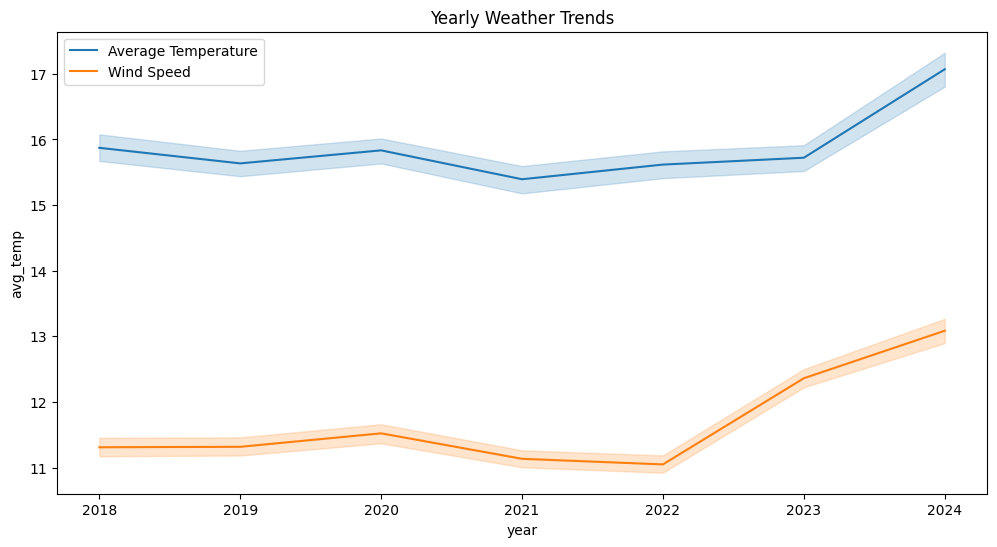

<Figure size 640x480 with 0 Axes>

In [13]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive map visualization by city
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=5)

# Add markers
for index, row in data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=row['location'],
        color='blue'
    ).add_to(m)

# Save map
m.save('weather_map.html')

# Yearly trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='avg_temp', data=data, label='Average Temperature')
sns.lineplot(x='year', y='wind_speed', data=data, label='Wind Speed')
plt.title('Yearly Weather Trends')
plt.legend()
plt.show()

# Save plot
plt.savefig('yearly_weather_trends.png')


In [15]:
import folium
import pandas as pd
from folium import CircleMarker, LayerControl
from folium.plugins import HeatMap


# Calculate the average coordinates to center the map
latitude_mean = data['latitude'].mean()
longitude_mean = data['longitude'].mean()

# Create the base map
m = folium.Map(location=[latitude_mean, longitude_mean], zoom_start=5)

# Add circle markers for each city with detailed weather information in the popup
for index, row in data.iterrows():
    popup_text = (f"<b>City:</b> {row['location']}<br>"
                  f"<b>Avg Temp:</b> {row['avg_temp']}°C<br>"
                  f"<b>Min Temp:</b> {row['min_temp']}°C<br>"
                  f"<b>Max Temp:</b> {row['max_temp']}°C<br>"
                  f"<b>Wind Speed:</b> {row['wind_speed']} km/h<br>"
                  f"<b>Precipitation:</b> {row['precipitation']} mm<br>"
                  f"<b>Snowfall:</b> {row['snowfall']} cm<br>"
                  f"<b>Wind Direction:</b> {row['wind_direction']}°")

    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        popup=folium.Popup(popup_text, max_width=300),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# Add a heatmap for average temperature
heat_data = [[row['latitude'], row['longitude'], row['avg_temp']] for index, row in data.iterrows() if pd.notna(row['avg_temp'])]
HeatMap(heat_data, radius=15).add_to(m)

# Add layer control to toggle between layers
LayerControl().add_to(m)

# Add legend to the map for better context
legend_html = """
<div style="position: fixed;
    bottom: 50px; left: 50px; width: 300px; height: 120px;
    background-color: white; z-index:9999; font-size:14px;
    border:2px solid grey; padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-circle" style="color:blue"></i> City Marker<br>
    <i class="fa fa-circle" style="color:green"></i> Temperature Heatmap<br>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# Save map to HTML
m.save('weather_map_detailed.html')


In [16]:
# Convert 'time' column to datetime format for better handling
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

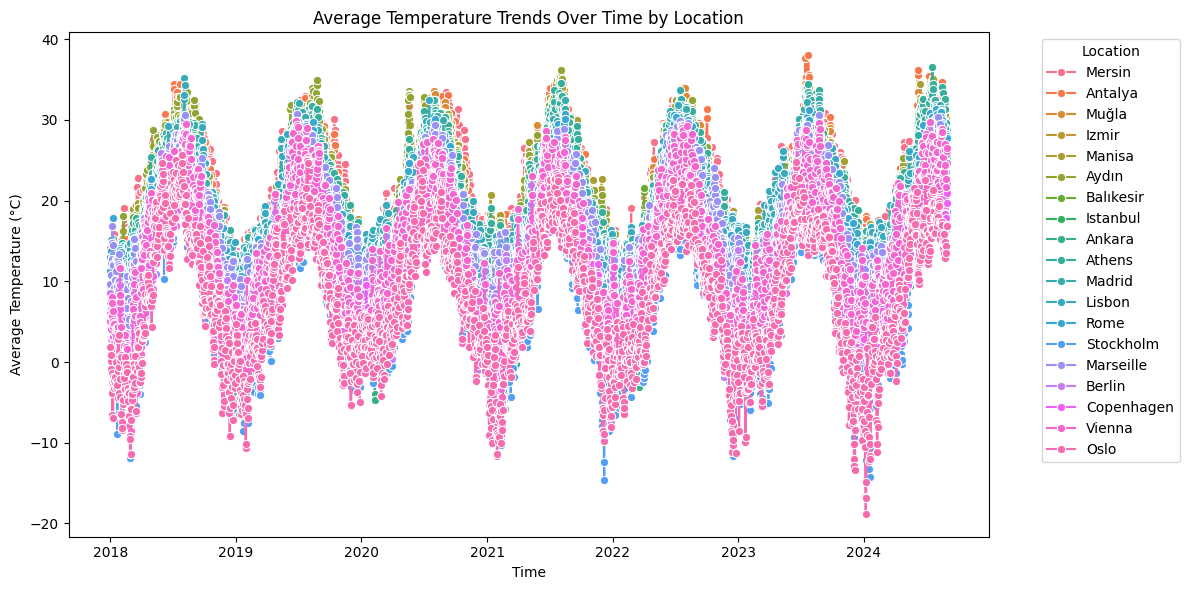

In [17]:
# Line plot for temperature trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='avg_temp', hue='location', data=data, marker='o')
plt.title('Average Temperature Trends Over Time by Location')
plt.xlabel('Time')
plt.ylabel('Average Temperature (°C)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('avg_temp_trends.png')
plt.show()


C:\Users\doguk\AppData\Local\Temp\ipykernel_7944\2519961112.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='year', y='precipitation', hue='location', data=data, estimator=sum, ci=None)


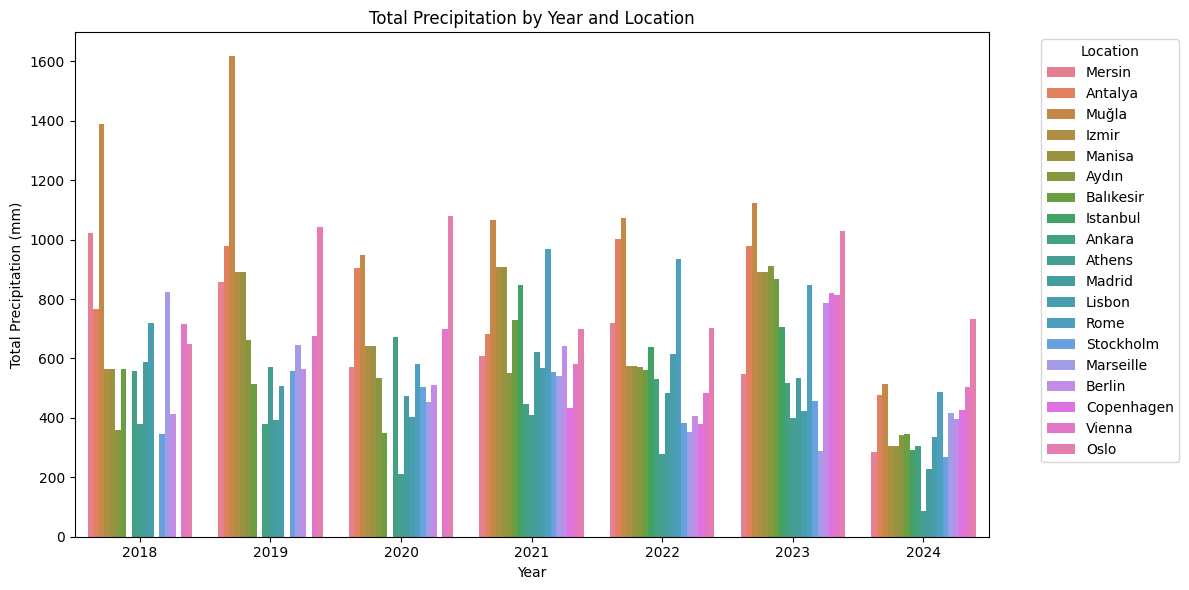

In [18]:
# Bar plot for total precipitation by year and location
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='precipitation', hue='location', data=data, estimator=sum, ci=None)
plt.title('Total Precipitation by Year and Location')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('total_precipitation_by_year.png')
plt.show()


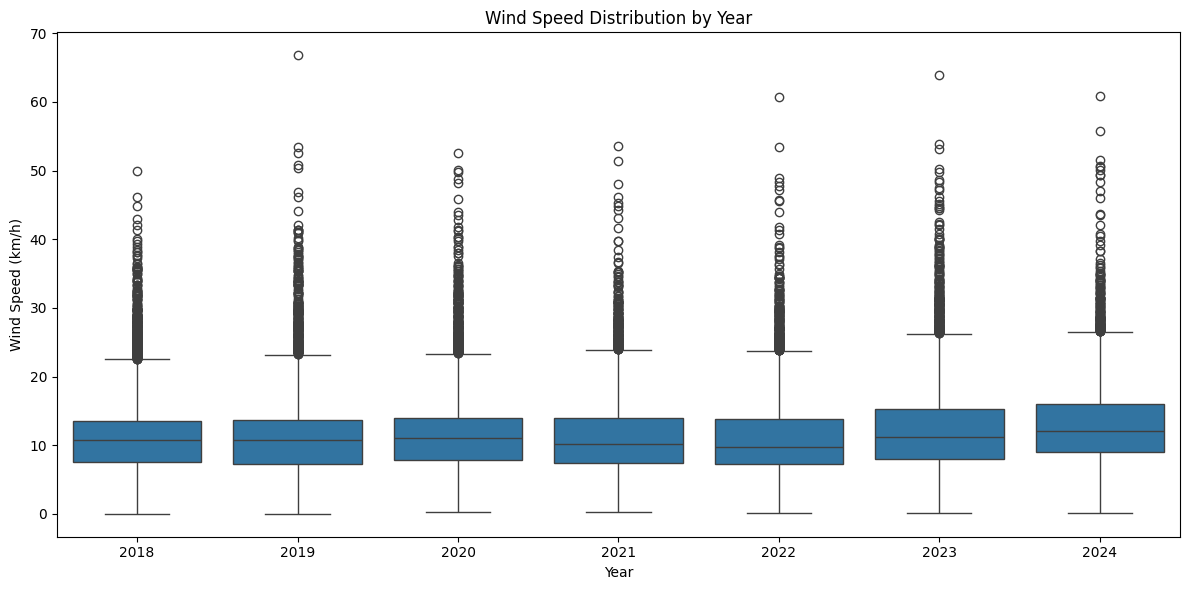

In [20]:
# Box plot for wind speed distribution by year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='wind_speed', data=data)
plt.title('Wind Speed Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Wind Speed (km/h)')
plt.tight_layout()
plt.savefig('wind_speed_distribution.png')
plt.show()


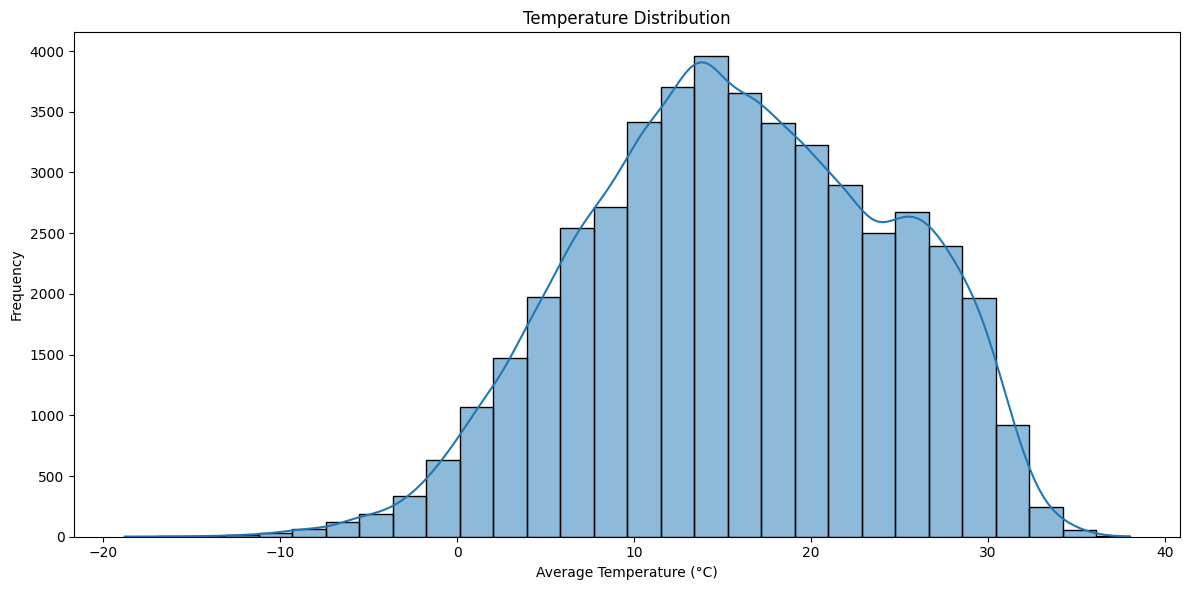

In [21]:
# Histogram for temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(data['avg_temp'], bins=30, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('temperature_distribution.png')
plt.show()


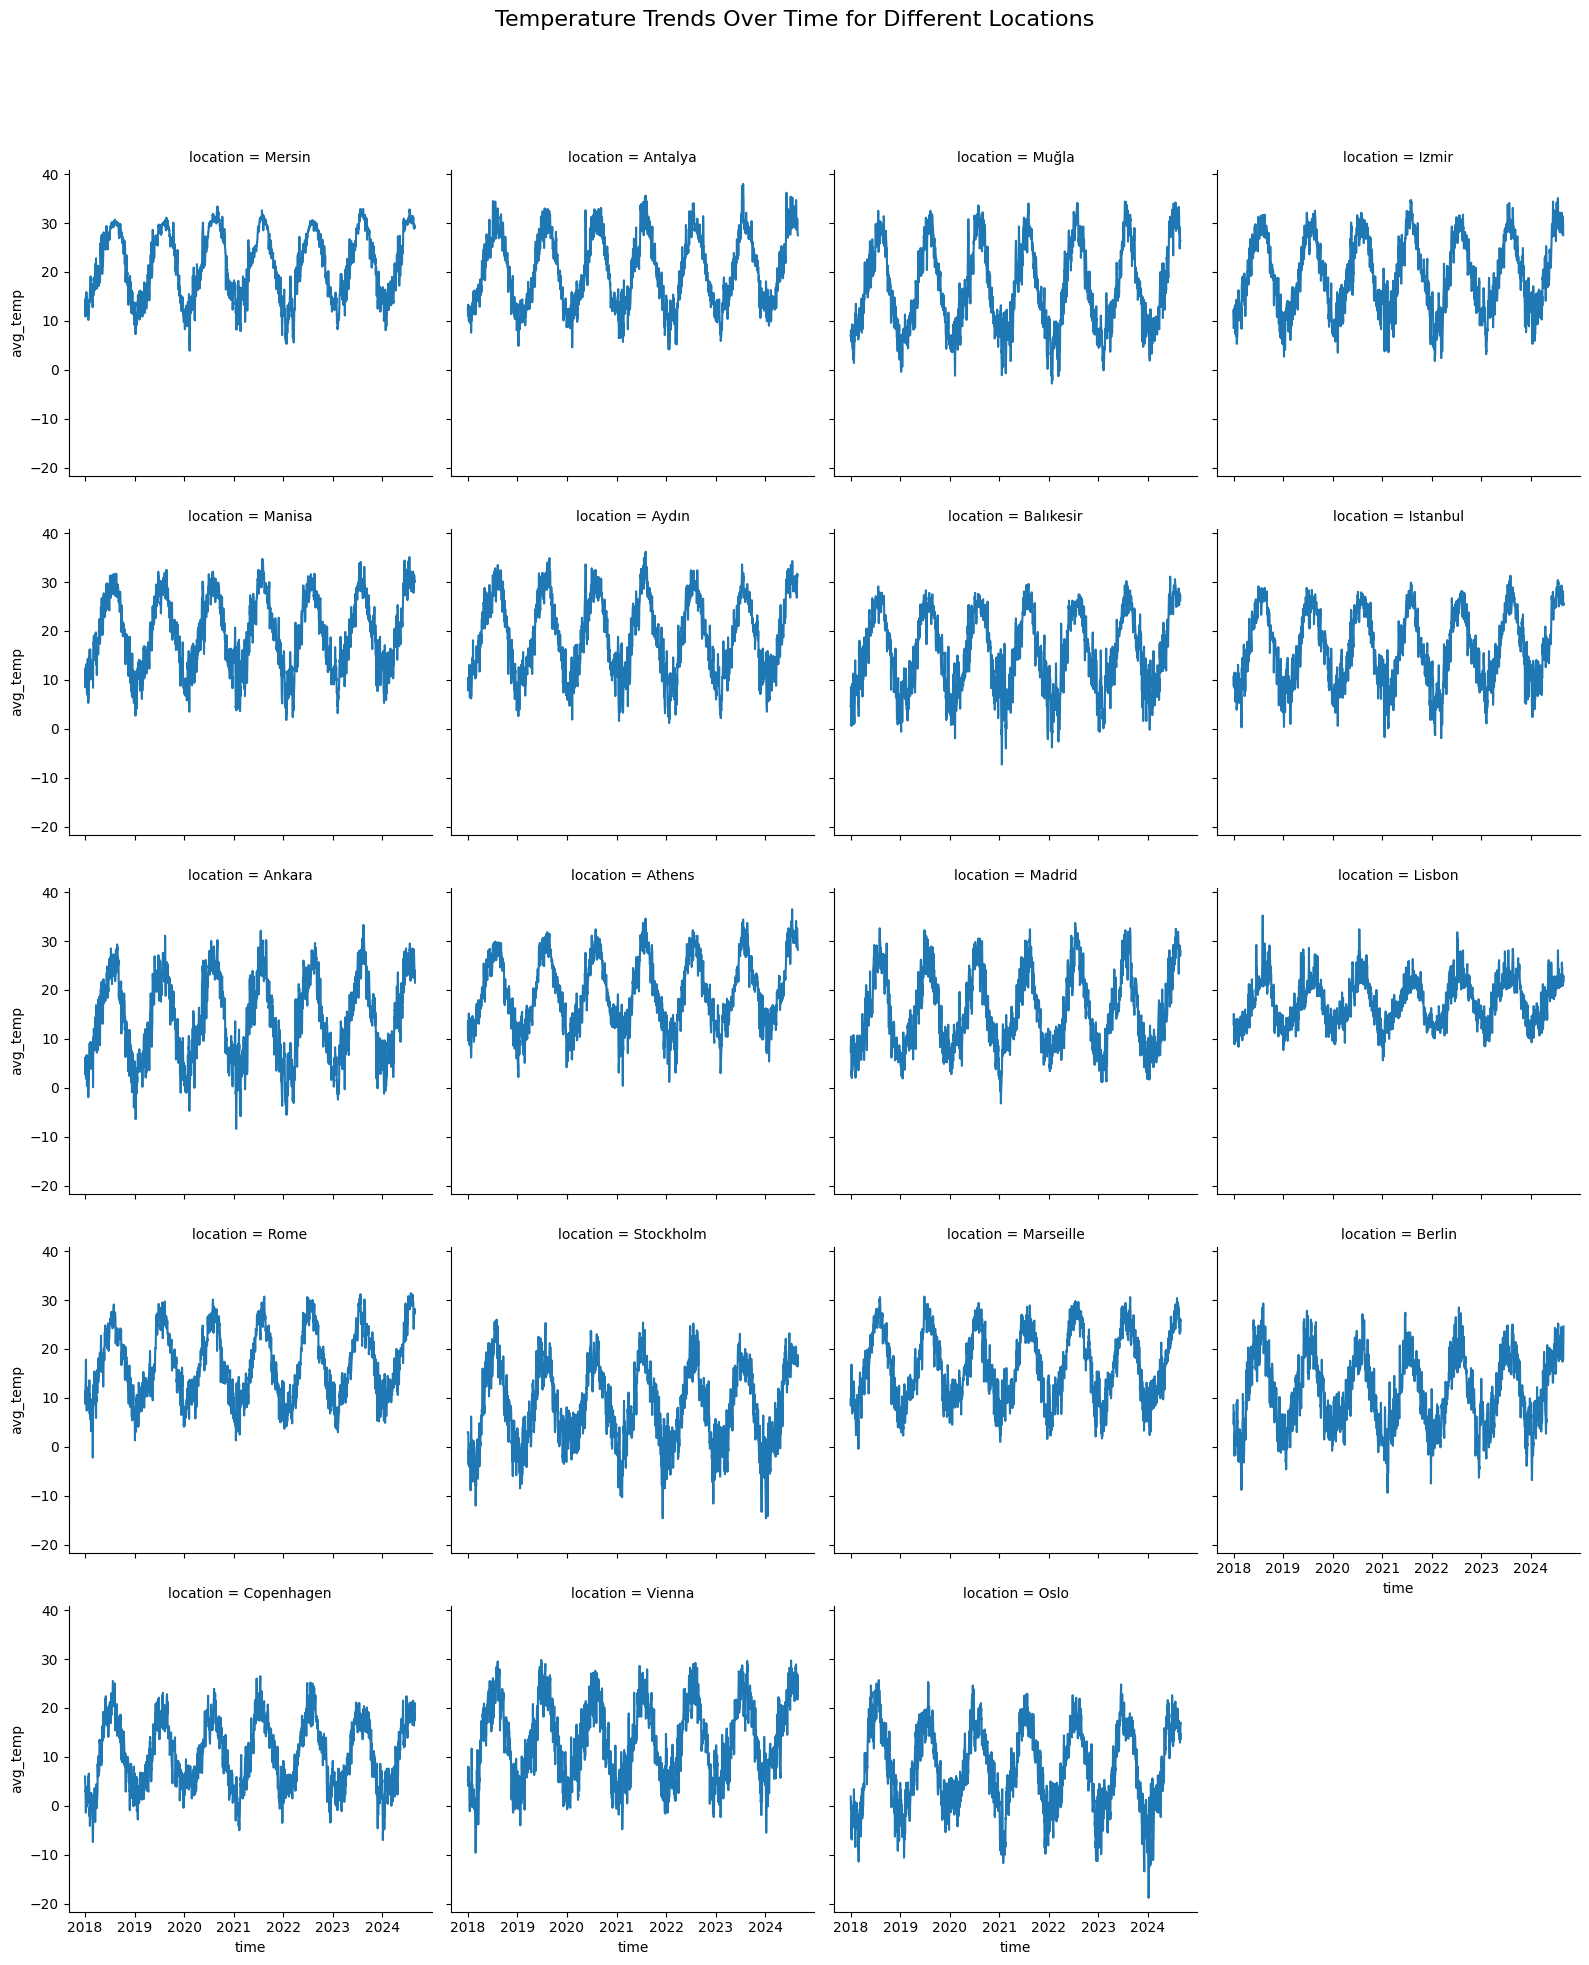

In [22]:
# FacetGrid for multiple visualizations
g = sns.FacetGrid(data, col="location", col_wrap=4, height=4)
g.map(sns.lineplot, 'time', 'avg_temp')
g.fig.suptitle('Temperature Trends Over Time for Different Locations', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.savefig('facetgrid_temperature_trends.png')
plt.show()


In [24]:
!pip install catboost

   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/101.1 MB 10.1 MB/s eta 0:00:10
   - -------------------------------------- 3.1/101.1 MB 8.4 MB/s eta 0:00:12
   - -------------------------------------- 4.5/101.1 MB 8.4 MB/s eta 0:00:12
   -- ------------------------------------- 5.8/101.1 MB 7.0 MB/s eta 0:00:14
   -- ------------------------------------- 7.1/101.1 MB 6.9 MB/s eta 0:00:14
   --- ------------------------------------ 8.4/101.1 MB 6.8 MB/s eta 0:00:14
   --- ------------------------------------ 10.0/101.1 MB 6.8 MB/s eta 0:00:14
   ---- ----------------------------------- 11.5/101.1 MB 6.9 MB/s eta 0:00:14
   ----- ---------------------------------- 13.1/101.1 MB 6.9 MB/s eta 0:00:13
   ----- ---------------------------------- 14.7/101.1 MB 7.0 MB/s eta 0:00:13
   ------ --------------------------------- 16.3/101.1 MB 7.1 MB/s eta 0:00:13
   ------- -------------------------------- 18.1/101.1 MB 7.1 MB/

In [26]:
from catboost import CatBoostClassifier

# Updated feature selection based on available columns
features = ['avg_temp', 'wind_speed', 'precipitation']
X = data[features]

# Create a label for anomalies (example: avg_temp > 35°C or wind speed > 100 km/h)
data['anomaly'] = ((data['avg_temp'] > 35) | (data['wind_speed'] > 100)).astype(int)
y = data['anomaly']

# Initialize and train CatBoost model
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6)
model.fit(X, y, verbose=False)

# Predict anomalies
data['anomaly_prediction'] = model.predict(X)

print(data[['time', 'location', 'avg_temp', 'wind_speed', 'precipitation', 'anomaly', 'anomaly_prediction']].head())


        time location  avg_temp  wind_speed  precipitation  anomaly  \
0 2018-01-01   Mersin      14.1        13.1           39.9        0   
1 2018-01-02   Mersin      13.8        13.1            0.0        0   
2 2018-01-03   Mersin      13.1        13.1            7.1        0   
3 2018-01-04   Mersin      10.9        13.1           38.4        0   
4 2018-01-05   Mersin      11.9        13.1           15.2        0   

   anomaly_prediction  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


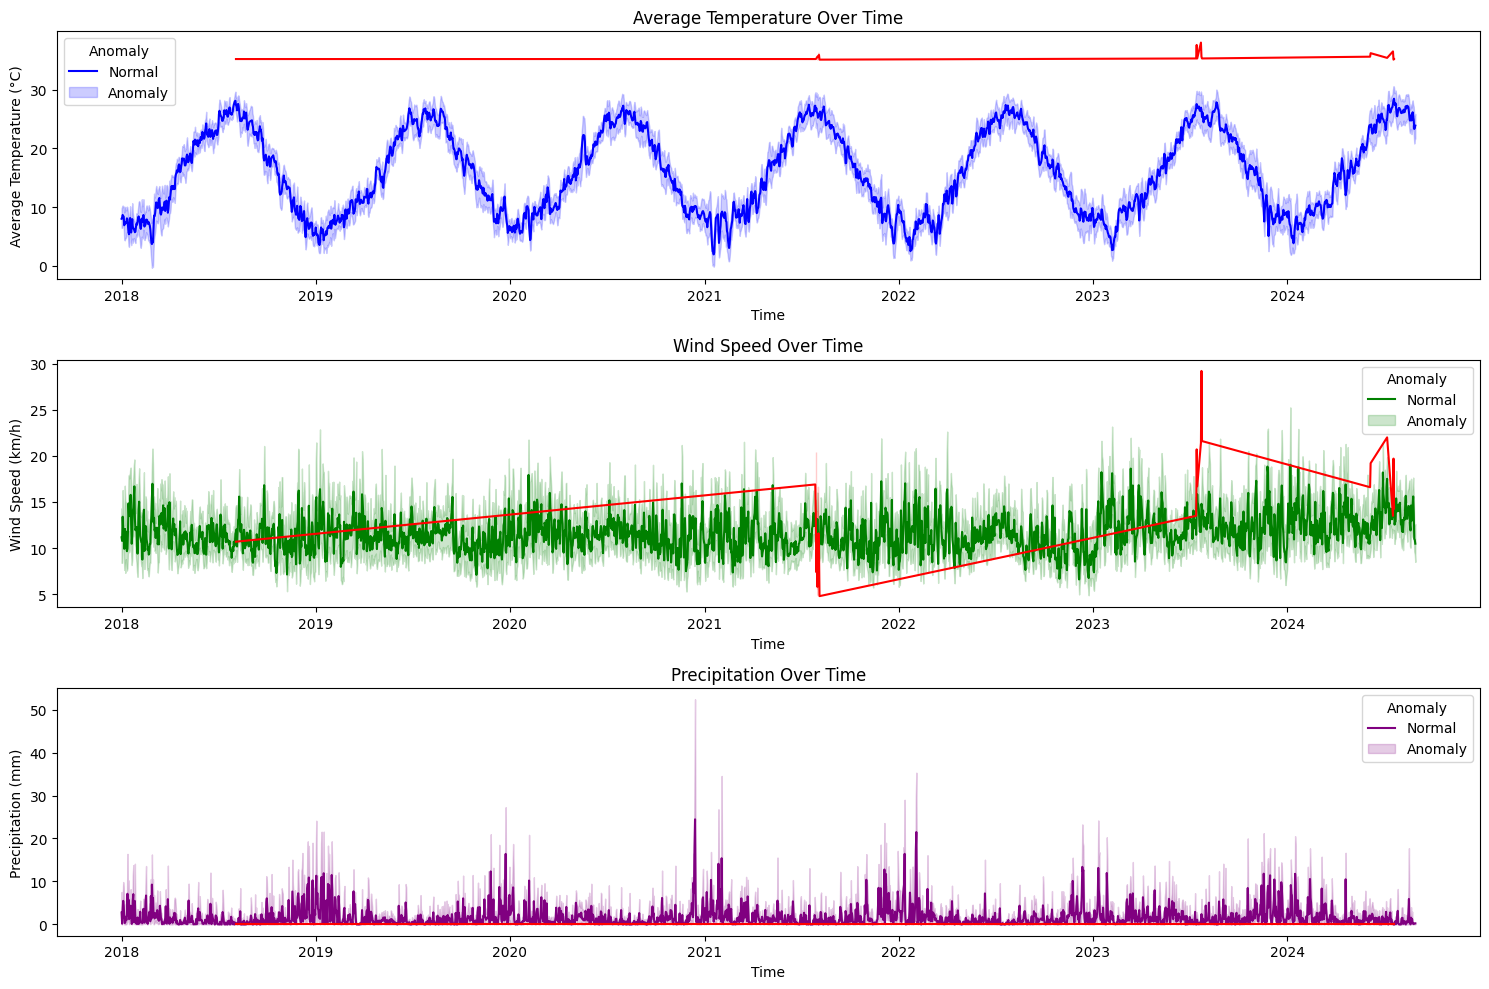

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

# Set up the figure for time series plots
plt.figure(figsize=(15, 10))

# Temperature over time
plt.subplot(3, 1, 1)
sns.lineplot(data=data, x='time', y='avg_temp', hue='anomaly', palette={0: 'blue', 1: 'red'})
plt.title('Average Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Average Temperature (°C)')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])

# Wind Speed over time
plt.subplot(3, 1, 2)
sns.lineplot(data=data, x='time', y='wind_speed', hue='anomaly', palette={0: 'green', 1: 'red'})
plt.title('Wind Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])

# Precipitation over time
plt.subplot(3, 1, 3)
sns.lineplot(data=data, x='time', y='precipitation', hue='anomaly', palette={0: 'purple', 1: 'red'})
plt.title('Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()


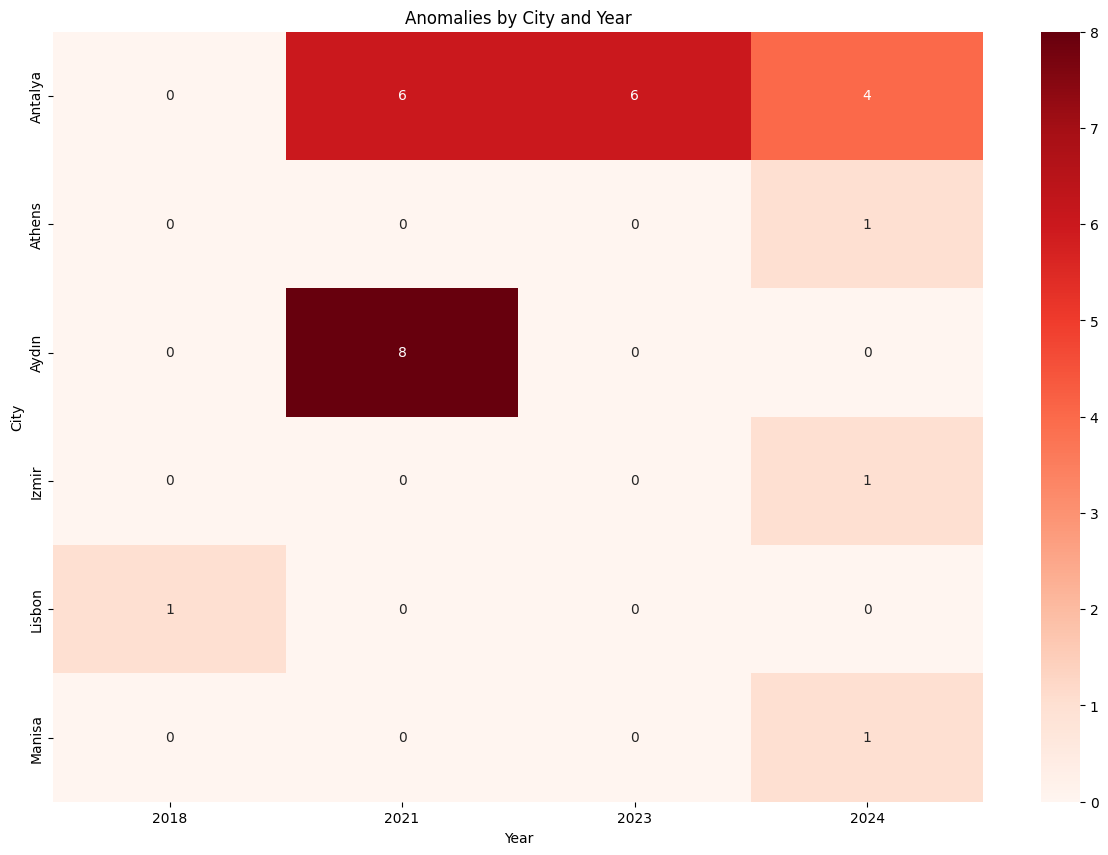

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 'year' column for grouping
data['year'] = pd.to_datetime(data['time']).dt.year

# Group by city and year to count anomalies
anomalies_by_city_year = data[data['anomaly'] == 1].groupby(['location', 'year']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
sns.heatmap(anomalies_by_city_year, annot=True, fmt='d', cmap='Reds')
plt.title('Anomalies by City and Year')
plt.xlabel('Year')
plt.ylabel('City')
plt.show()


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define features and target variable based on your actual data
forecast_features = ['avg_temp', 'wind_speed', 'precipitation']
forecast_target = 'avg_temp'

# Check if all forecast_features are in the DataFrame
missing_features = [feature for feature in forecast_features if feature not in data.columns]
if missing_features:
    raise ValueError(f"Missing columns in data: {missing_features}")

# Prepare the data for training
X = data[forecast_features].fillna(method='ffill').fillna(method='bfill')
y = data[forecast_target].fillna(method='ffill').fillna(method='bfill')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
forecast_model = RandomForestRegressor(n_estimators=100, random_state=42)
forecast_model.fit(X_train, y_train)

# Forecast future temperatures
future_temperatures = forecast_model.predict(X_test)

# Save model
joblib.dump(forecast_model, 'weather_forecast_model.pkl')

print("Model trained and saved successfully.")


C:\Users\doguk\AppData\Local\Temp\ipykernel_7944\3224406097.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[forecast_features].fillna(method='ffill').fillna(method='bfill')
C:\Users\doguk\AppData\Local\Temp\ipykernel_7944\3224406097.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[forecast_target].fillna(method='ffill').fillna(method='bfill')


Model trained and saved successfully.


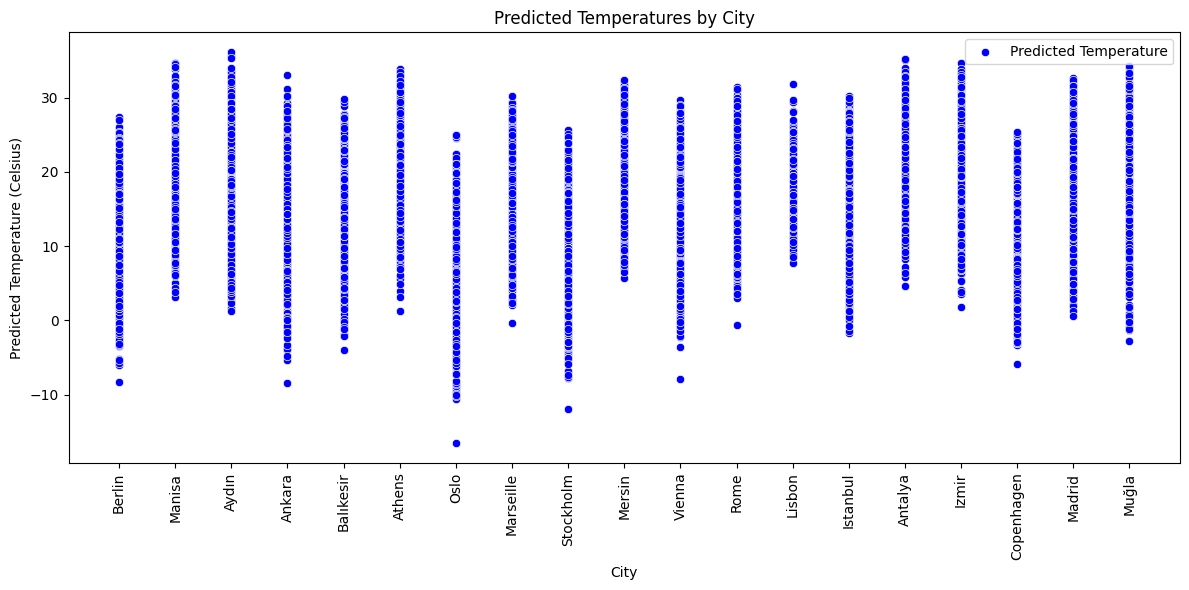

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'location' column exists in your data
# Ensure your predictions (future_temperatures) and X_test have corresponding indexes
X_test['predicted_temp'] = future_temperatures
X_test['location'] = data.loc[X_test.index, 'location']

# Plot the predicted temperatures by city
plt.figure(figsize=(12, 6))
sns.scatterplot(x='location', y='predicted_temp', data=X_test, color='blue', label='Predicted Temperature')
plt.xticks(rotation=90)
plt.title('Predicted Temperatures by City')
plt.xlabel('City')
plt.ylabel('Predicted Temperature (Celsius)')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Save plot
plt.savefig('predicted_temperatures_by_city.png')
